In [1]:
%matplotlib inline
from importlib import reload
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from itertools import product
from functools import partial
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.datasets.base import Bunch
from sklearn.utils.extmath import squared_norm
from sklearn.covariance import GraphLasso, empirical_covariance
from sklearn.datasets.base import Bunch
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.gaussian_process import kernels

from regain import prox; reload(prox)
from regain.covariance import time_graphical_lasso_; reload(time_graphical_lasso_);
import time

from regain.bayesian import wishart_process_; reload(wishart_process_)
from regain.bayesian import stats; reload(stats)

from regain import utils; reload(utils);


# ISING

In [4]:
#devo generare dati temporali.. nel dubbio potrei farli tutti uguali, per cominciare
#import regain.datasets.time; reload(regain.datasets.time)
#import regain._datasets.ising; reload(regain._datasets.ising)
import regain.datasets; reload(regain.datasets)
from regain.datasets import make_dataset

samples, thetas = make_dataset(
        n_samples=100, n_dim_obs=50,  T=10,  update_theta='l1',
 distribution='ising', change=2)

l1


In [6]:
# import pickle as pkl
# with open("../../../../projects/time_exponential_family/data/data_ising_temporal_test_100nodes.pkl", "wb") as f:
#     pkl.dump([samples, thetas], f)

In [7]:
# with open("../../../../projects/time_exponential_family/data/data_ising_temporal_test_50nodes.pkl", "rb") as f:
#     samples, thetas = pkl.load(f)

In [8]:
import regain.generalized_linear_model.ising; reload(regain.generalized_linear_model.ising)
from regain.generalized_linear_model.ising import IsingGraphicalModel
import regain.model_selection.stability_optimization; reload(regain.model_selection.stability_optimization)

from regain.model_selection.stability_optimization import GraphicalModelStabilitySelection

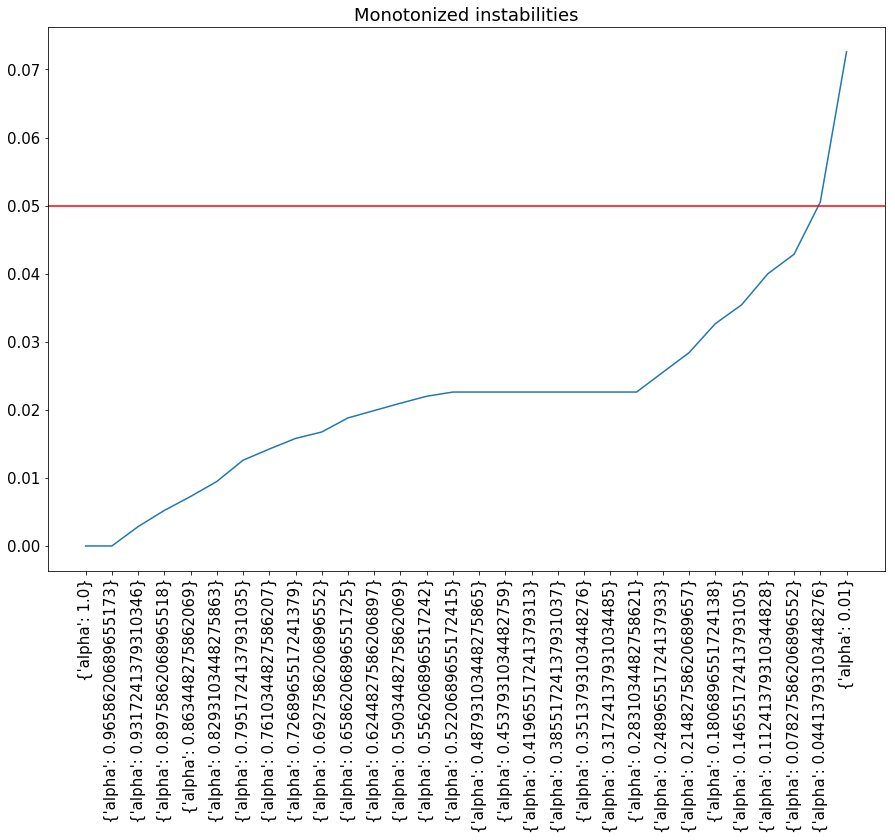

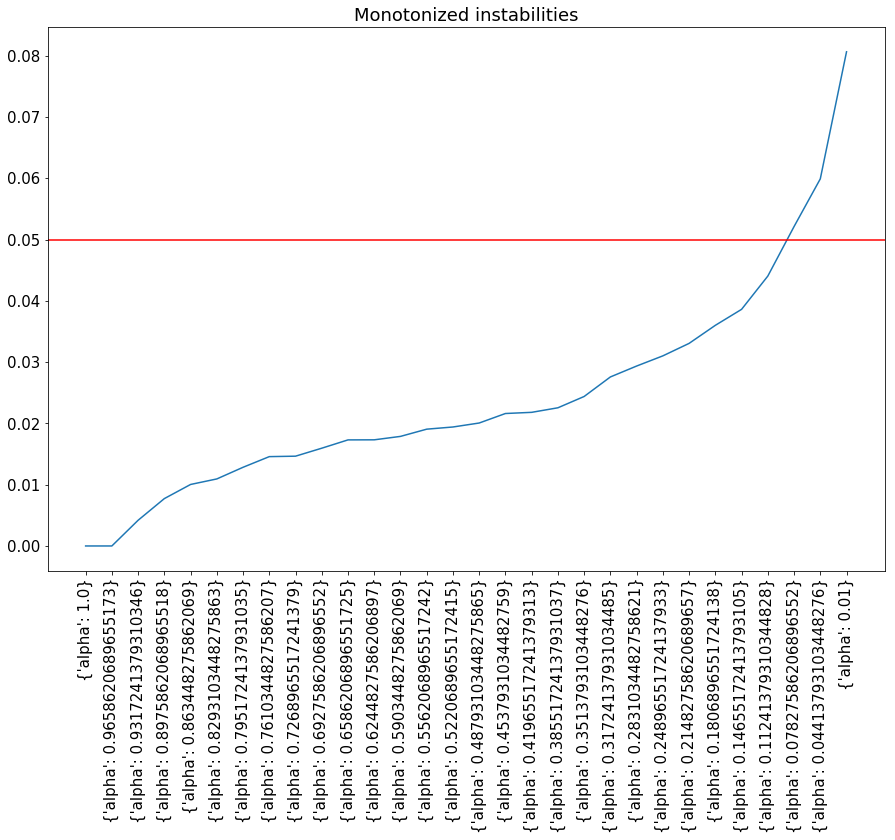

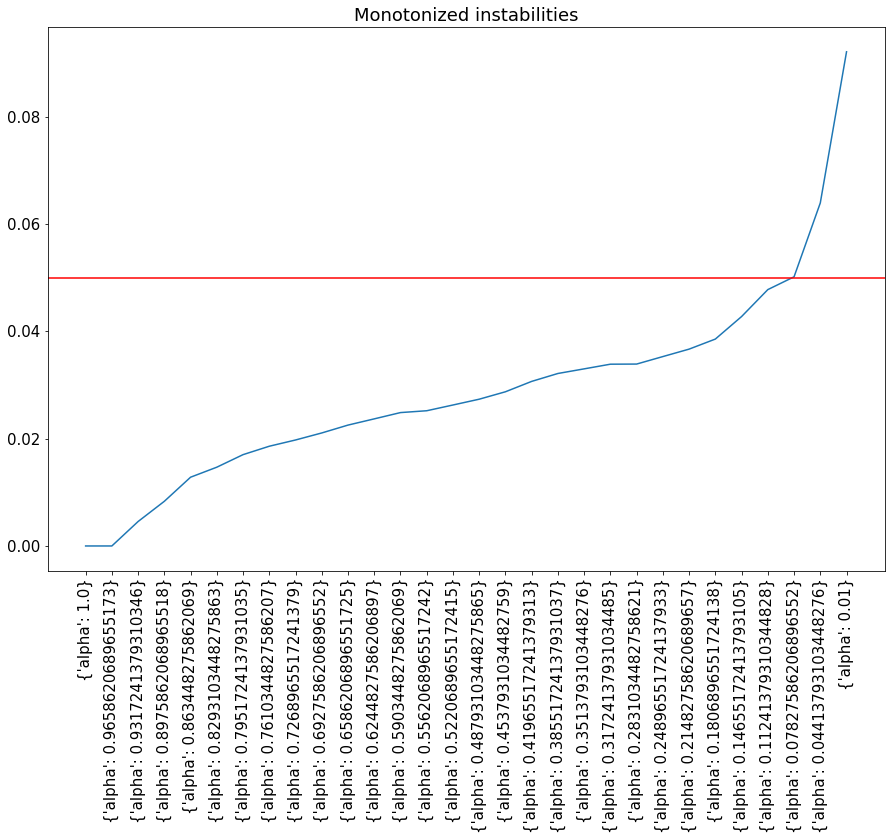

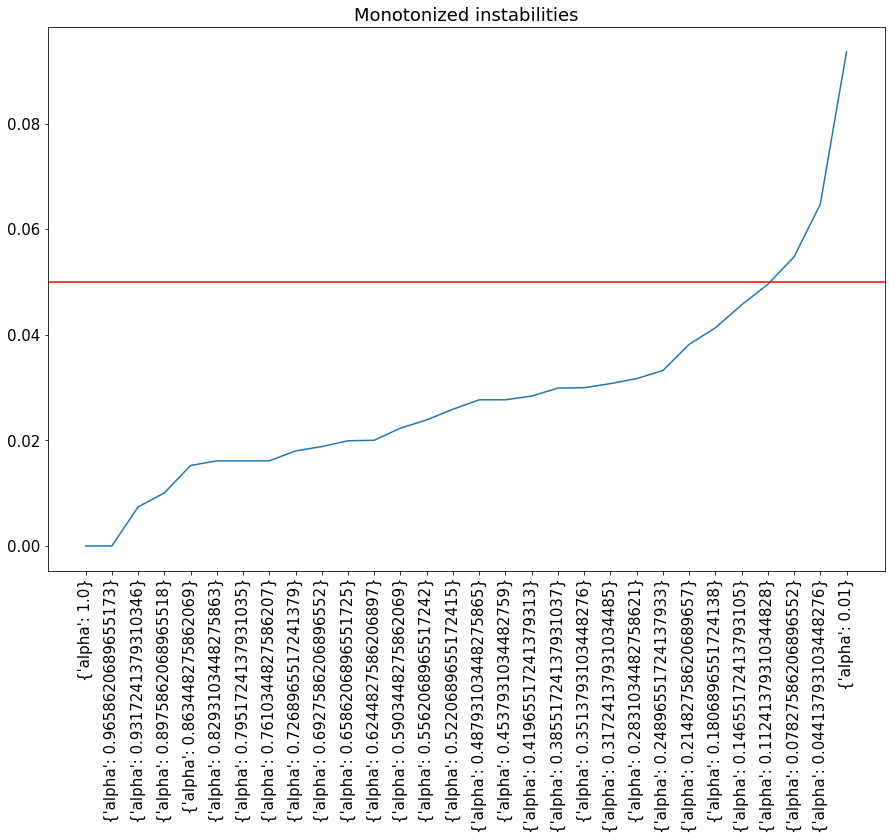

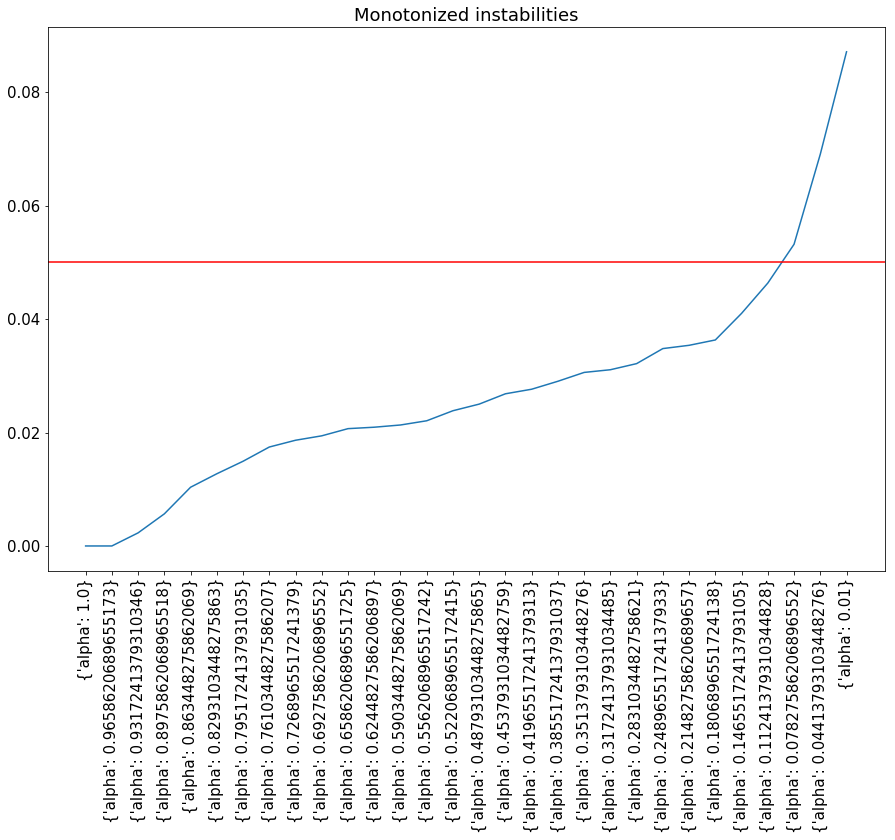

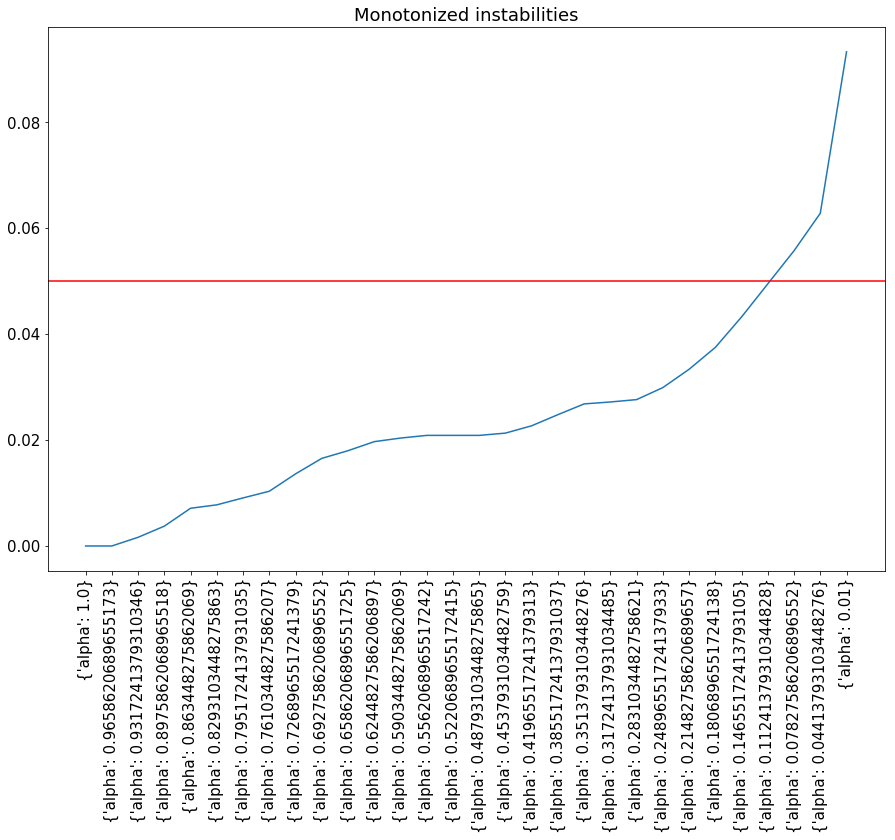

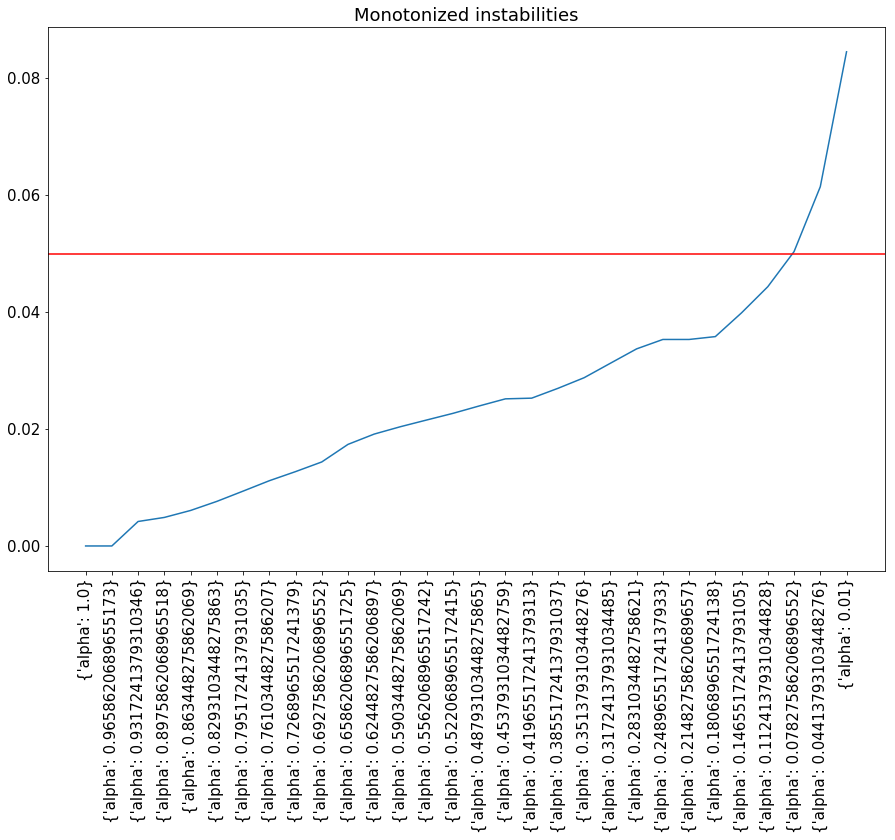

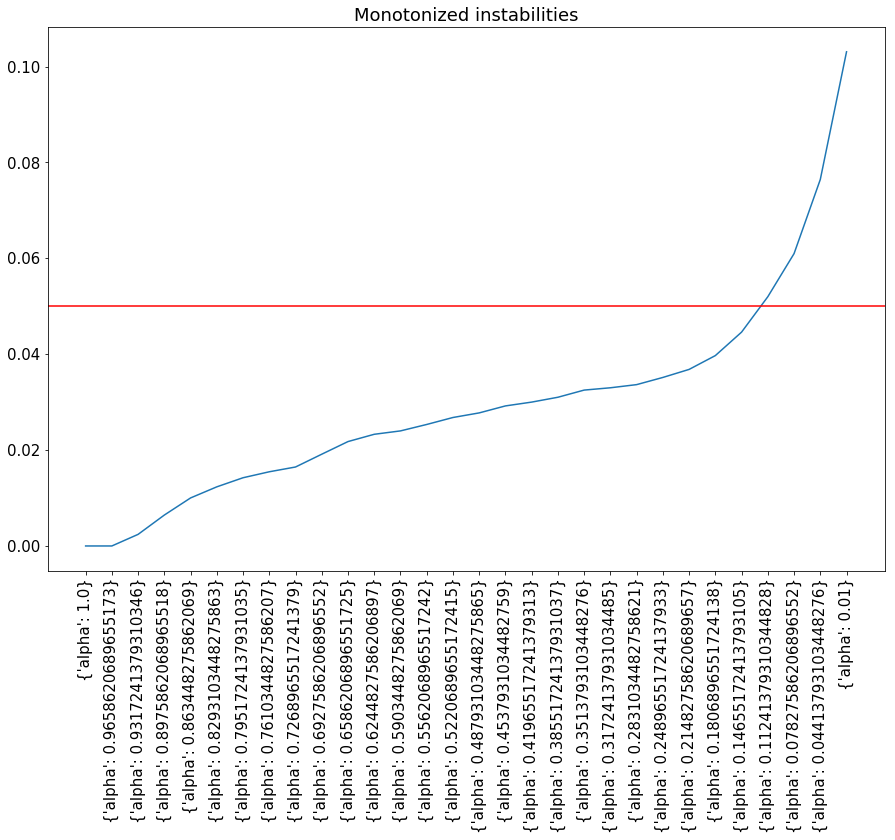

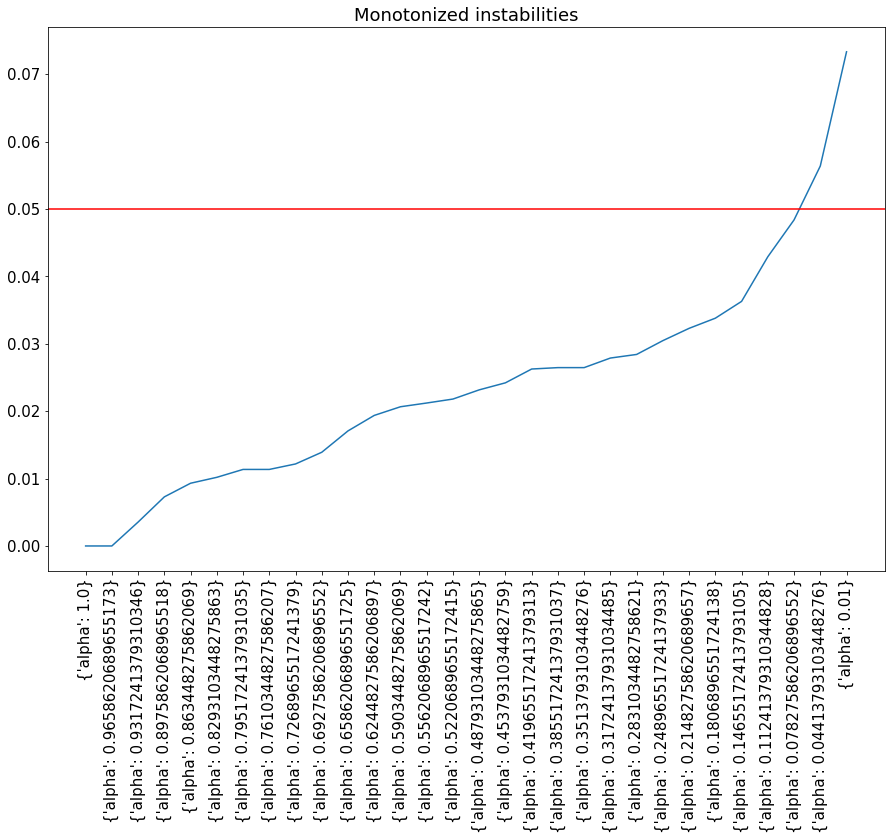

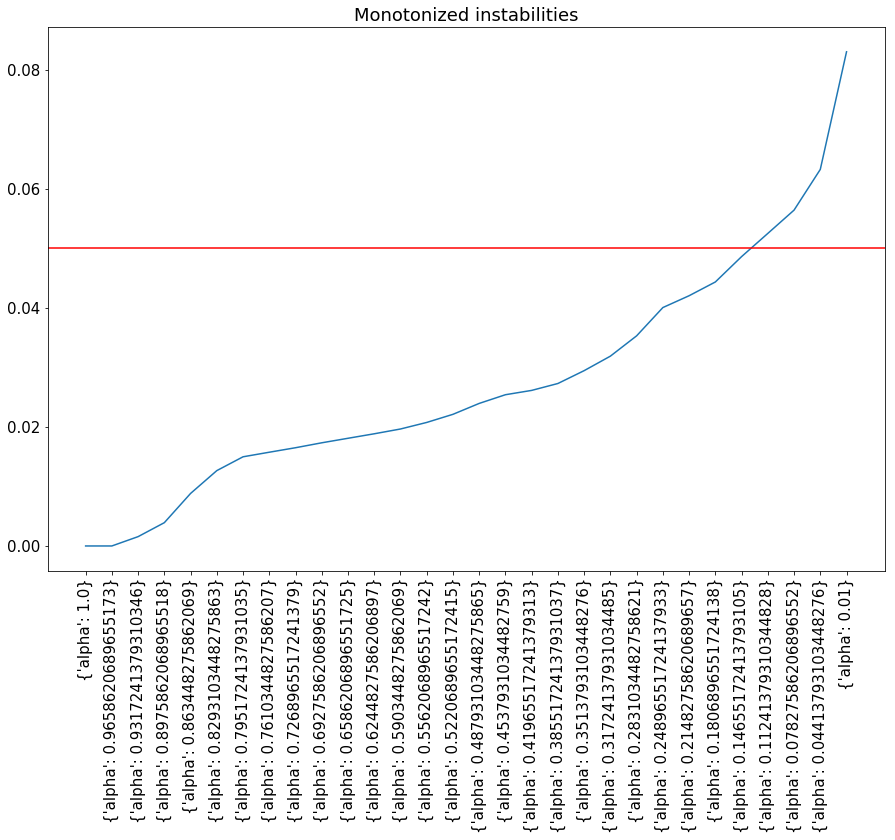

In [9]:
ising_mdl = IsingGraphicalModel(alpha=0.32, mode='symmetric_fbs', verbose=0)

params = []
estimators = []
for i in range(10):
    cv = GraphicalModelStabilitySelection(ising_mdl, param_grid={'alpha':np.linspace(0.01, 1, 30)},
                                          sampling_size=80,
                                         n_repetitions=20)
    cv.fit(samples[i])
    params.append(cv.best_params_['alpha'])
    estimators.append(cv.best_estimator_)
    cv.plot()

In [10]:
from sklearn.model_selection import ShuffleSplit

sss = ShuffleSplit(n_splits=10)

precisions = []
for train, test in sss.split(samples[0]):
    precs= []
    for i, e in enumerate(estimators):
        e.fit(samples[i][train, :])
        precs.append(e.precision_)
    precisions.append(np.array(precs))

In [ ]:
precisions[0].shape

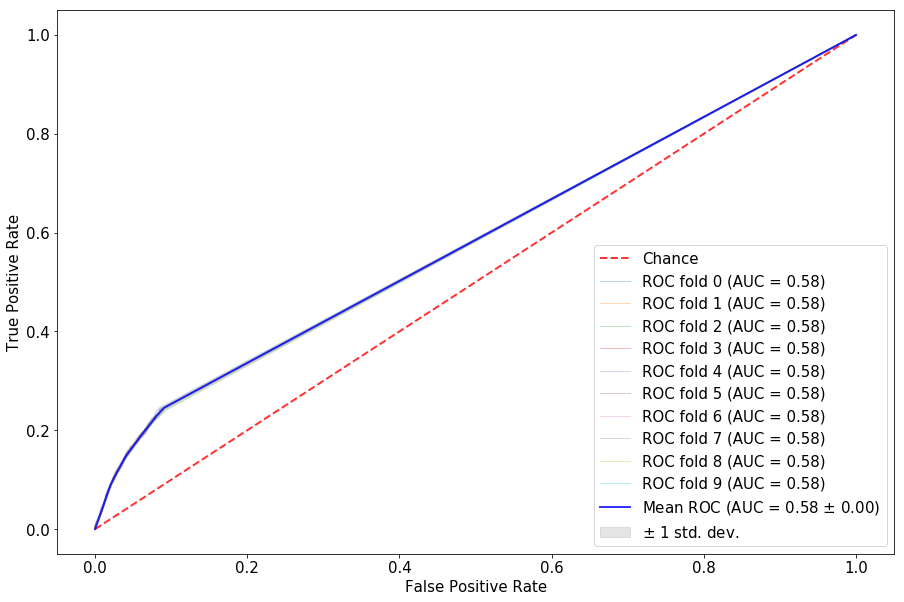

In [11]:
from regain.plotting.results import plot_roc_curves
plot_roc_curves(np.array(thetas), [np.abs(p) for p in precisions])

In [34]:
thetas

[array([[ 0., -1., -1., ...,  0.,  0., -1.],
        [-1.,  0.,  0., ..., -1.,  1.,  1.],
        [-1.,  0.,  0., ..., -1.,  1.,  1.],
        ...,
        [ 0., -1., -1., ...,  0.,  0., -1.],
        [ 0.,  1.,  1., ...,  0.,  0.,  1.],
        [-1.,  1.,  1., ..., -1.,  1.,  0.]]),
 array([[ 0., -1., -1., ...,  0.,  0., -1.],
        [-1.,  0.,  0., ..., -1.,  1.,  1.],
        [-1.,  0.,  0., ..., -1.,  1.,  1.],
        ...,
        [ 0., -1., -1., ...,  0.,  0., -1.],
        [ 0.,  1.,  1., ...,  0.,  0.,  1.],
        [-1.,  1.,  1., ..., -1.,  1.,  0.]]),
 array([[ 0., -1., -1., ...,  0.,  0., -1.],
        [-1.,  0.,  0., ..., -1.,  1.,  1.],
        [-1.,  0.,  0., ..., -1.,  1.,  1.],
        ...,
        [ 0., -1., -1., ...,  0.,  0., -1.],
        [ 0.,  1.,  1., ...,  0.,  0.,  1.],
        [-1.,  1.,  1., ..., -1.,  1.,  0.]]),
 array([[ 0., -1., -1., ...,  0.,  0., -1.],
        [-1.,  0.,  0., ..., -1.,  1.,  1.],
        [-1.,  0.,  0., ..., -1.,  1.,  1.],
        ..

In [40]:
utils.structure_error(np.array(thetas), np.array(precisions[0]), no_diagonal=True)

{'tp': 3898,
 'tn': 7844,
 'fp': 772,
 'fn': 11986,
 'precision': 0.8346895074946467,
 'recall': 0.2454041803072274,
 'f1': 0.37929356816191495,
 'accuracy': 0.46968,
 'false_omission_rate': 0.6044377206253152,
 'fdr': 0.16531049250535332,
 'npv': 0.3955622793746848,
 'prevalence': 0.63536,
 'miss_rate': 0.7545958196927726,
 'fall_out': 0.08960074280408542,
 'specificity': 0.9103992571959145,
 'plr': 2.7388632351386937,
 'nlr': 0.8288625168884407,
 'dor': 3.3043637265929426,
 'balanced_accuracy': 0.5779017187515709,
 'average_precision': 0.47418880715506306,
 'mcc': 0.33525140652064145}

In [ ]:
import pickle as pkl

In [12]:
with open("../../../../projects/time_exponential_family/results_ising/results_single_100nodes.pkl", "wb") as f:
    pkl.dump([precisions, params], f)


In [ ]:
import regain.model_selection.stability_optimization; reload(regain.model_selection.stability_optimization)
from regain.model_selection.stability_optimization import GraphicalModelStabilitySelection
mdl = TemporalIsingModel(
        alpha=np.mean(params),  psi='l1', assume_centered=True, rtol=1e-5, tol=1e-4,
        max_iter=300, rho=1.,  kernel=kernel,  init='zeros', verbose=0)

cv = GraphicalModelStabilitySelection(mdl, param_grid={'alpha':np.linspace(0.001, 0.1, 20)},
                                      sampling_size=800,
                                      n_repetitions=20)
cv.fit(X, y)

(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)

(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)

(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)

(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)

(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)

(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)

(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)

(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)

(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)

(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)

(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)

(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)

(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)

(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)

(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)

(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)

(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)

(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)

(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)

(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)

(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)

(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)

(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)

(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)

(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)

In [13]:
#import regain.generalized_linear_model.time; reload(regain.generalized_linear_model.time)
from regain.generalized_temporal_linear_model.ising import TemporalIsingModel

from sklearn.gaussian_process import kernels

kernel = kernels.RBF(length_scale=2)(np.arange(10)[:, None])
#kernel = np.ones((10,10))*1
#np.fill_diagonal(kernel, 1)
mdl = TemporalIsingModel(
        alpha=np.mean(params),  psi='l1', assume_centered=True, rtol=1e-5, tol=1e-4,
        max_iter=300, rho=1.,  kernel=kernel,  init='zeros', verbose=0)

X = np.vstack(samples)
y = np.array([np.ones(x.shape[0]) * i
              for i, x in enumerate(samples)]).flatten().astype(int)
#base_results(mdl, X, y, K, thetas, ells, search_spaces=None)

In [ ]:
mdl.fit(X, y)

In [27]:
import regain.generalized_temporal_linear_model.ising; reload( regain.generalized_temporal_linear_model.ising)
from regain.generalized_temporal_linear_model.ising import TemporalIsingModel
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=5)

precisions_time = []
for train, test in sss.split(X, y):
    mdl.fit(X[train, :], y[train])
    precisions_time.append(mdl.precision_)

(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)

(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)

(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)
(10, 50, 50)

In [39]:
precisions[0].shape

(10, 50, 50)

In [44]:
import regain.utils; reload(regain.utils)
from regain.utils import mean_structure_error

mean_structure_error(np.array(thetas), precisions)

{'tp': '3862.8+/-26.38484413446477',
 'tn': '7813.8+/-17.94324385388551',
 'fp': '802.2+/-17.943243853885505',
 'fn': '12021.2+/-26.38484413446477',
 'precision': '0.8280357976187572+/-0.0039060037042960784',
 'recall': '0.24318811382523292+/-0.0016610957022453274',
 'f1': '0.3759584432165807+/-0.002317737039857099',
 'accuracy': '0.467064+/-0.0016246304195108483',
 'false_omission_rate': '0.6060596237610278+/-0.0009786765945358547',
 'fdr': '0.17196420238124277+/-0.0039060037042960736',
 'npv': '0.3939403762389722+/-0.000978676594535852',
 'prevalence': '0.6353600000000001+/-1.1102230246251565e-16',
 'miss_rate': '0.756811886174767+/-0.0016610957022453496',
 'fall_out': '0.09310584958217269+/-0.0020825491938121533',
 'specificity': '0.9068941504178273+/-0.002082549193812134',
 'plr': '2.6135116694936307+/-0.07090405975847429',
 'nlr': '0.8345168272025539+/-0.003426303457404478',
 'dor': '3.1321578663494853+/-0.0973309084703909',
 'mcc': '0.33027894905739397+/-0.0030156993544202563',
 

In [45]:
mean_structure_error(np.array(thetas), precisions_time)

{'tp': '3206.4+/-41.093065108361046',
 'tn': '8026.4+/-9.748846085563153',
 'fp': '589.6+/-9.748846085563152',
 'fn': '12677.6+/-41.093065108361046',
 'precision': '0.8446571220169201+/-0.0033036606009874386',
 'recall': '0.20186351045076806+/-0.0025870728474163313',
 'f1': '0.3258470453835665+/-0.003578241874585323',
 'accuracy': '0.44931200000000004+/-0.0018504745337345153',
 'false_omission_rate': '0.612324639092351+/-0.0009323706851825788',
 'fdr': '0.15534287798307994+/-0.003303660600987427',
 'npv': '0.38767536090764887+/-0.0009323706851825461',
 'prevalence': '0.63536+/-0.0',
 'miss_rate': '0.798136489549232+/-0.0025870728474163434',
 'fall_out': '0.06843082636954503+/-0.0011314816719548704',
 'specificity': '0.9315691736304549+/-0.0011314816719548693',
 'plr': '2.950972423976197+/-0.07354819229804868',
 'nlr': '0.8567684374636919+/-0.0033728712510595663',
 'dor': '3.444674877402906+/-0.09843102832590142',
 'mcc': '0.31458507741787173+/-0.0037256703726388923',
 'balanced_accurac

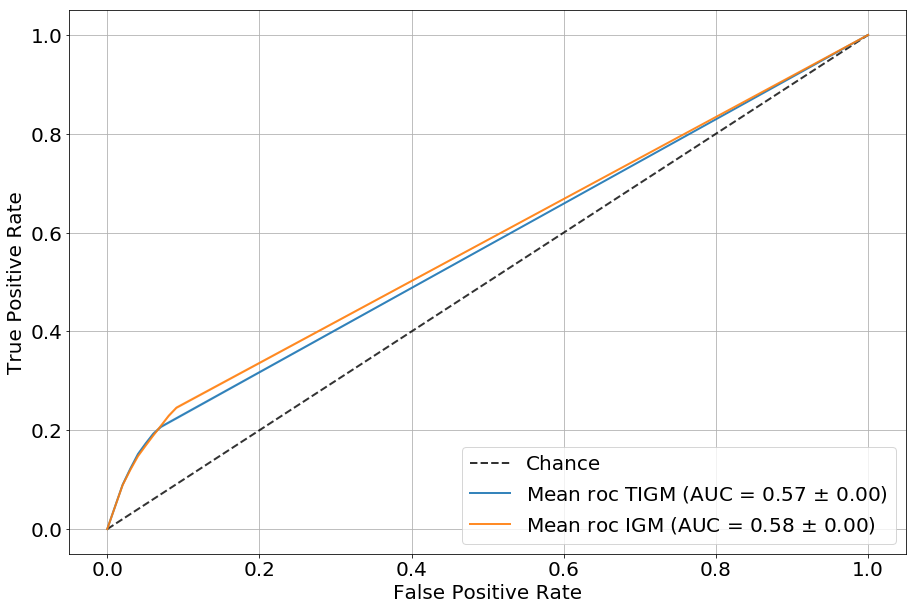

In [48]:
import regain.plotting.results; reload(regain.plotting.results)
from regain.plotting.results import plot_curve

plot_curve(np.abs(np.array(thetas)), {'TIGM':[np.abs(p) for p in precisions_time],
                                                'IGM':[np.abs(p) for p in precisions]},
          filename='/home/vero/Dropbox (DIBRIS)/PhD/PhD thesis/Images/roc_ising_50_nodi.pdf', fontsize=20)

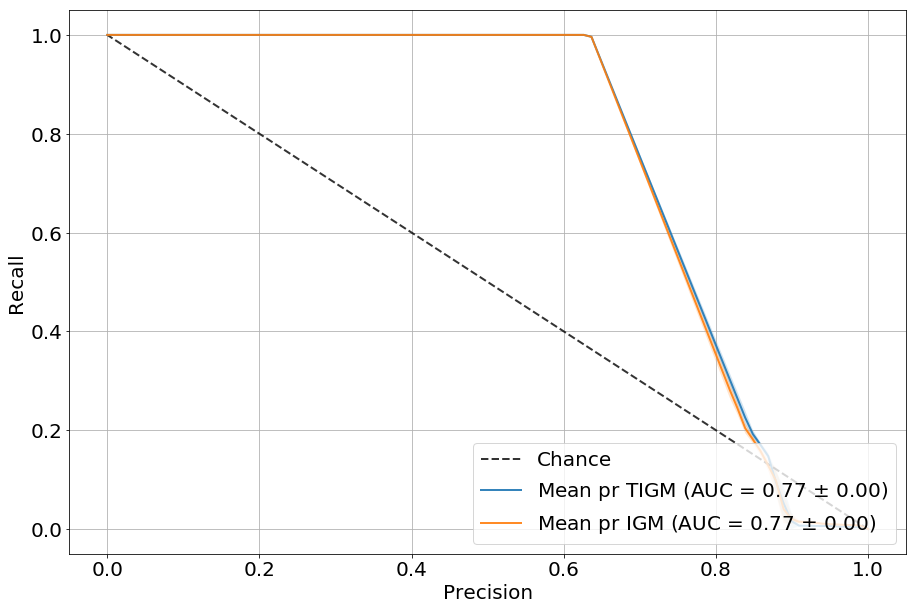

In [49]:
import regain.plotting.results; reload(regain.plotting.results)
from regain.plotting.results import plot_curve

plot_curve(np.abs(np.array(thetas)), {'TIGM':[np.abs(p) for p in precisions_time],
                                                'IGM':[np.abs(p) for p in precisions]}, mode='pr',
            filename='/home/vero/Dropbox (DIBRIS)/PhD/PhD thesis/Images/pr_ising_50_nodi.pdf', fontsize=20)

In [ ]:
import regain.utils; reload(regain.utils)
from regain.utils import structure_error, mean_structure_error

In [ ]:
mean_structure_error(np.array(thetas), [np.abs(p) for p in precisions])

In [ ]:
mean_structure_error(np.array(thetas), [np.abs(p) for p in precisions_time])